#**Academic Grand Challenge on Climate Change**
#Team - Hack and Cheese

> Hyagreev Rethinavel

> Viboosithasri N S

> Nakul R

> Suberus Heartrisha G









##Model Used to predict the occurrences of heat waves and the Air Quality Index (AQI) : 
#**TFT - Temporal Fusion Transformer**

#1. Predict the occurrences of heat waves

In [ ]:
#installing pytorch-lightning
pip install pytorch-lightning==1.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.6/518.6 KB 27.9 MB/s eta 0:00:00


In [ ]:
#installing pytorch_forecasting
pip install pytorch_forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.4/141.4 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.2/31.2 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 KB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.2/147.2 KB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 KB 8.9 MB/s eta 0:00:00
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=f56cefc6c7bff8ca578f1333689f6be8bd17f3749e

In [ ]:
#importing necessary packages/modules
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
import matplotlib.pyplot as plt
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting import NaNLabelEncoder

In [ ]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

Reading the dataset and preprocessing

In [ ]:
#Renaming column names
col_names = ["District",	"Mandal",	"Date",	"Rain (mm)",	"Min Temp (°C)",	"Max Temp (°C)",	"Min Humidity (%)",	"Max Humidity (%)",	"Min Wind Speed (Kmph)",	"Max Wind Speed (Kmph)"]

In [ ]:
#reading the dataset
data=pd.read_csv("/content/Final_Heat_Wave.csv", names = col_names)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3,4,5,6,7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
#dropping first row
data = data.drop(0)

In [ ]:
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

In [ ]:
data

,District,Mandal,Date,Rain (mm),Min Temp (°C),Max Temp (°C),Min Humidity (%),Max Humidity (%),Min Wind Speed (Kmph),Max Wind Speed (Kmph)
1,Adilabad,Adilabad Rural,2019-01-01,0,7.1,26.4,19,73.7,0,14.1
2,Adilabad,Adilabad Rural,2019-01-02,0,9.1,28.9,16.6,73.4,0,7.8
3,Adilabad,Adilabad Rural,2019-01-03,0,13,31.6,21.1,70.2,0,7.7
4,Adilabad,Adilabad Rural,2019-01-04,0,9.9,31.2,24.1,82.4,0,6.9
5,Adilabad,Adilabad Rural,2019-01-05,0,12.7,31.2,27,76.8,0,5.8
...,...,...,...,...,...,...,...,...,...,...
139836,Warangal,Wardhannapet,2022-12-27,0.0,20.5,32.1,71.5,100.0,0.0,7.5
139837,Warangal,Wardhannapet,2022-12-28,0.0,21.7,33.4,60.0,100.0,0.0,3.9
139838,Warangal,Wardhannapet,2022-12-29,0.0,19.3,33.9,49.7,100.0,0.0,4.3
139839,Warangal,Wardhannapet,2022-12-30,0.0,20.1,33.1,49.7,100.0,0.0,3.1


In [ ]:
# add time index - defining day wise time index
Date = data['Date'].min()
data["time_idx"] = data['Date'] - Date
data["time_idx"] = data["time_idx"].dt.days
data[["time_idx"]].astype(int)

#adding additional features
data["target"] = data.shift(-1)["Max Temp (°C)"]

,time_idx
1,0
2,1
3,2
4,3
5,4
...,...
139836,1456
139837,1457
139838,1458
139839,1459


In [ ]:
data['District'] = data['District'].astype(str)
data['Mandal'] = data['Mandal'].astype(str)
data['Min Humidity (%)'] = data['Min Humidity (%)'].astype(float)
data['Rain (mm)'] = data['Rain (mm)'].astype(float)
data['Min Temp (°C)'] = data['Min Temp (°C)'].astype(float)
data['Max Temp (°C)'] = data['Max Temp (°C)'].astype(float)
data['Max Humidity (%)'] = data['Max Humidity (%)'].astype(float)
data['Min Wind Speed (Kmph)'] = data['Min Wind Speed (Kmph)'].astype(float)
data['Max Wind Speed (Kmph)'] = data['Max Wind Speed (Kmph)'].astype(float)

In [ ]:
data.dtypes

District                         object
Mandal                           object
Date                     datetime64[ns]
Rain (mm)                       float64
Min Temp (°C)                   float64
Max Temp (°C)                   float64
Min Humidity (%)                float64
Max Humidity (%)                float64
Min Wind Speed (Kmph)           float64
Max Wind Speed (Kmph)           float64
time_idx                          int64
dtype: object

In [ ]:
data['Min Humidity (%)'] = data['Min Humidity (%)'].replace(np.nan, 0)
data['Max Humidity (%)'] = data['Max Humidity (%)'].replace(np.nan, 0)
data['Min Wind Speed (Kmph)'] = data['Min Wind Speed (Kmph)'].replace(np.nan, 0)
data['Max Wind Speed (Kmph)'] = data['Max Wind Speed (Kmph)'].replace(np.nan, 0)

In [ ]:
data.isnull().sum()

District                 0
Mandal                   0
Date                     0
Rain (mm)                0
Min Temp (°C)            0
Max Temp (°C)            0
Min Humidity (%)         0
Max Humidity (%)         0
Min Wind Speed (Kmph)    0
Max Wind Speed (Kmph)    0
time_idx                 0
dtype: int64

In [ ]:
data

,District,Mandal,Date,Rain (mm),Min Temp (°C),Max Temp (°C),Min Humidity (%),Max Humidity (%),Min Wind Speed (Kmph),Max Wind Speed (Kmph),time_idx,target
1,Adilabad,Adilabad Rural,2019-01-01,0.0,7.1,26.4,19.0,73.7,0.0,14.1,0,28.9
2,Adilabad,Adilabad Rural,2019-01-02,0.0,9.1,28.9,16.6,73.4,0.0,7.8,1,31.6
3,Adilabad,Adilabad Rural,2019-01-03,0.0,13.0,31.6,21.1,70.2,0.0,7.7,2,31.2
4,Adilabad,Adilabad Rural,2019-01-04,0.0,9.9,31.2,24.1,82.4,0.0,6.9,3,31.2
5,Adilabad,Adilabad Rural,2019-01-05,0.0,12.7,31.2,27.0,76.8,0.0,5.8,4,31.8
...,...,...,...,...,...,...,...,...,...,...,...,...
139835,Warangal,Wardhannapet,2022-12-26,0.0,20.1,32.4,44.7,100.0,0.0,4.1,1455,32.1
139836,Warangal,Wardhannapet,2022-12-27,0.0,20.5,32.1,71.5,100.0,0.0,7.5,1456,33.4
139837,Warangal,Wardhannapet,2022-12-28,0.0,21.7,33.4,60.0,100.0,0.0,3.9,1457,33.9
139838,Warangal,Wardhannapet,2022-12-29,0.0,19.3,33.9,49.7,100.0,0.0,4.3,1458,33.1


In [ ]:
# data[data['Min Humidity (%)'].isna()]

,District,Mandal,Date,Rain (mm),Min Temp (°C),Max Temp (°C),Min Humidity (%),Max Humidity (%),Min Wind Speed (Kmph),Max Wind Speed (Kmph),time_idx,target


In [ ]:
data[data['target'].isna()]

,District,Mandal,Date,Rain (mm),Min Temp (°C),Max Temp (°C),Min Humidity (%),Max Humidity (%),Min Wind Speed (Kmph),Max Wind Speed (Kmph),time_idx,target
139840,Warangal,Wardhannapet,2022-12-31,0.0,18.5,33.6,44.5,100.0,0.0,4.4,1460,NaN


In [ ]:
data = data.drop(139840)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139839 entries, 1 to 139839
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   District               139839 non-null  object        
 1   Mandal                 139839 non-null  object        
 2   Date                   139839 non-null  datetime64[ns]
 3   Rain (mm)              139839 non-null  float64       
 4   Min Temp (°C)          139839 non-null  float64       
 5   Max Temp (°C)          139839 non-null  float64       
 6   Min Humidity (%)       139839 non-null  float64       
 7   Max Humidity (%)       139839 non-null  float64       
 8   Min Wind Speed (Kmph)  139839 non-null  float64       
 9   Max Wind Speed (Kmph)  139839 non-null  float64       
 10  time_idx               139839 non-null  int64         
 11  target                 139839 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1), 

In [ ]:
data.isnull().sum()

District                 0
Mandal                   0
Date                     0
Rain (mm)                0
Min Temp (°C)            0
Max Temp (°C)            0
Min Humidity (%)         0
Max Humidity (%)         0
Min Wind Speed (Kmph)    0
Max Wind Speed (Kmph)    0
time_idx                 0
target                   0
dtype: int64

In [ ]:
#data["target"] = data["target"].replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [ ]:
# data.to_csv('/content/sample.csv')

Create dataset and dataloaders

In [169]:
max_prediction_length = 365 #to predict 2023 heat wave occurrence
max_encoder_length = 1460 #giving lookback period as 4 years/1460 days
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Max Temp (°C)",
    group_ids=["District", "Mandal"],
    min_encoder_length=max_encoder_length // 2,  # keeping encoder length long 
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["District", "Mandal"],
    static_reals=[],
    time_varying_known_categoricals=[],
    variable_groups=[], 
    time_varying_known_reals=["time_idx","Rain (mm)",	"Min Temp (°C)",	"Min Humidity (%)",	"Max Humidity (%)",	"Min Wind Speed (Kmph)",	"Max Wind Speed (Kmph)"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["target"],
    categorical_encoders = [],
    target_normalizer=GroupNormalizer(
        groups=["District", "Mandal"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
    #predict = False
  
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 32  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

/usr/local/lib/python3.8/dist-packages/pytorch_forecasting/data/timeseries.py:1282: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 10 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__District': 'Adilabad', '__group_id__Mandal': 'Bela '}, {'__group_id__District': 'Adilabad', '__group_id__Mandal': 'Boath '}, {'__group_id__District': 'Adilabad', '__group_id__Mandal': 'Jainad '}, {'__group_id__District': 'Adilabad', '__group_id__Mandal': 'Talamadugu '}, {'__group_id__District': 'Karimnagar', '__group_id__Mandal': 'Jammikunta '}, {'__group_id__District': 'Karimnagar', '__group_id__Mandal': 'Manakondur '}, {'__group_id__District': 'Khammam', '__group_id__Mandal': 'Raghunadhapalem '}, {'__group_id__District': 'Khammam', '__group_id__Mandal': 'Tirumalayapalem'}, {'__group_id__District': 'Nizamabad', '__group_id_

Create baseline model

In [170]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
b = Baseline()
baseline_predictions = b.predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


6.298468589782715

Train the Temporal Fusion Transformer

In [171]:
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [172]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=3,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=0,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 28.7k


In [173]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 2.0 K 
3  | prescalers                         | ModuleDict                      | 192   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.0 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 5.9 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 5.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Evaluate performance

In [174]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [175]:
best_model_path

'lightning_logs/lightning_logs/version_3/checkpoints/epoch=9-step=300.ckpt'

In [176]:
# calcualte mean absolute percentage error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
x1=(((actuals - predictions).abs())/actuals.abs())
x1.mean()

tensor(0.0759)

In [177]:
#Mean average absolute error
m1=(predictions - actuals).abs()
m1.mean()

tensor(2.7111)

In [178]:
#SMAPE -  Symmetric mean absolute percentage
s1=2*(actuals - predictions).abs() / (actuals.abs() + predictions.abs()+ 1e-8)
s1.mean()

tensor(0.0796)

In [179]:
#RMSE - Root mean square error
r1=(predictions - actuals)**2
r1
r1=r1.mean()
r1=r1.sqrt()
accuracy = 1.96*r1
print(r1)
print(accuracy)

tensor(3.3148)
tensor(6.4969)


In [180]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

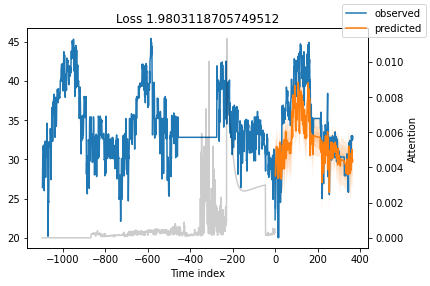

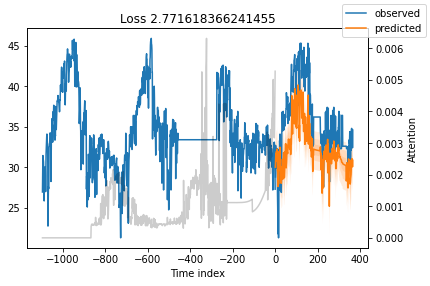

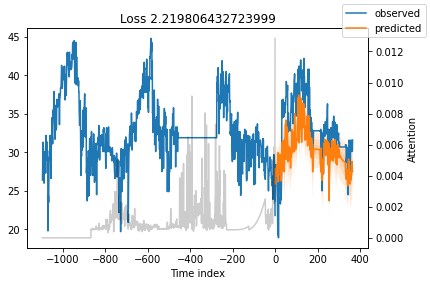

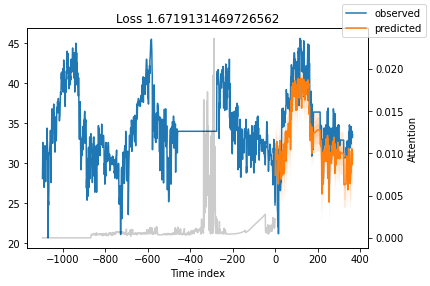

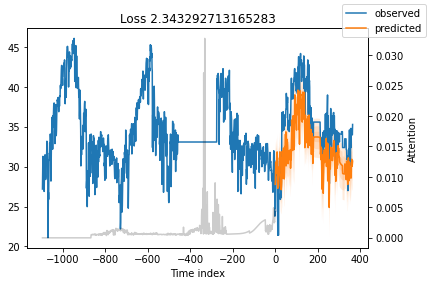

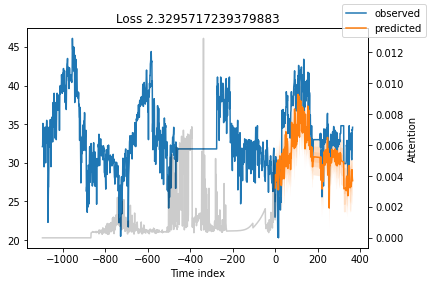

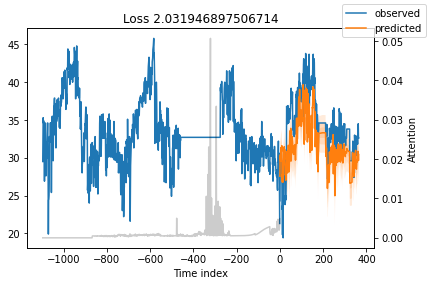

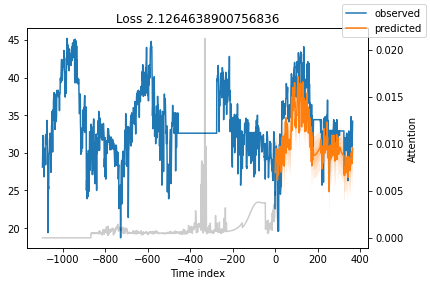

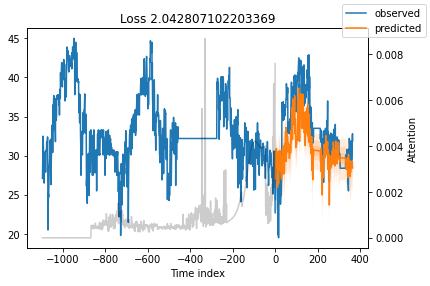

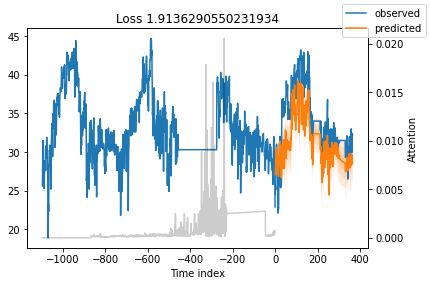

In [181]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

Actuals vs predictions by variables

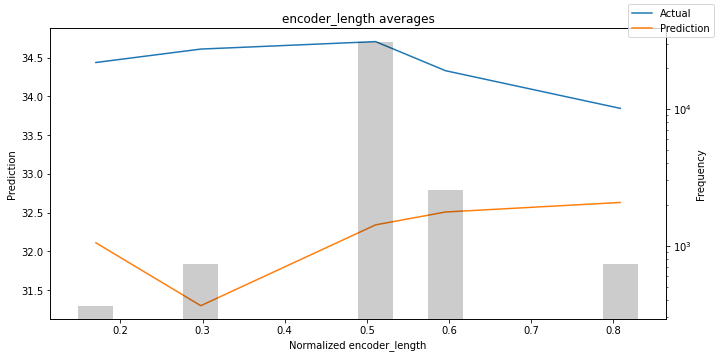

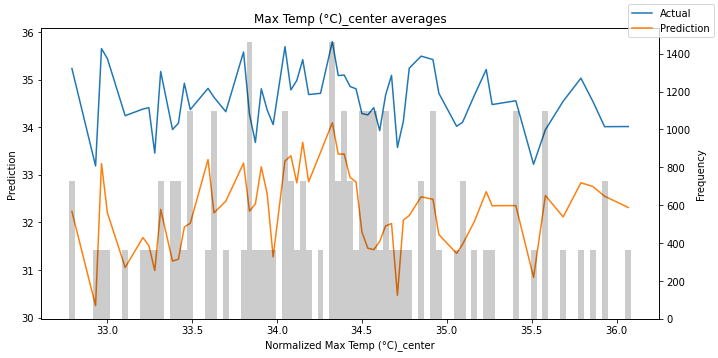

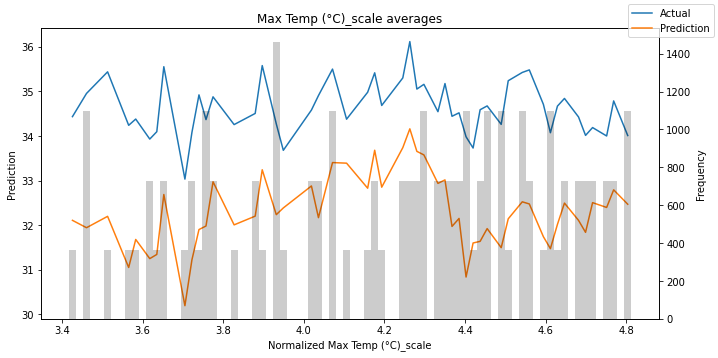

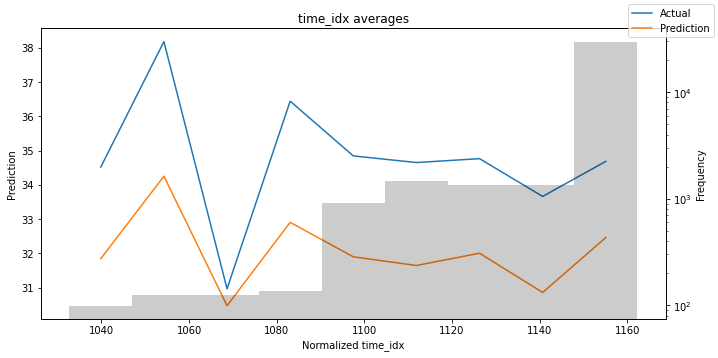

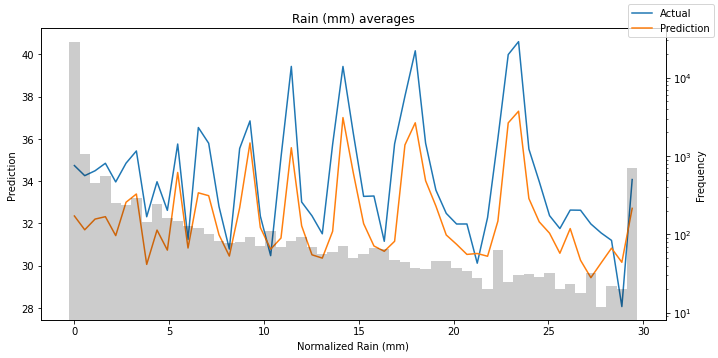

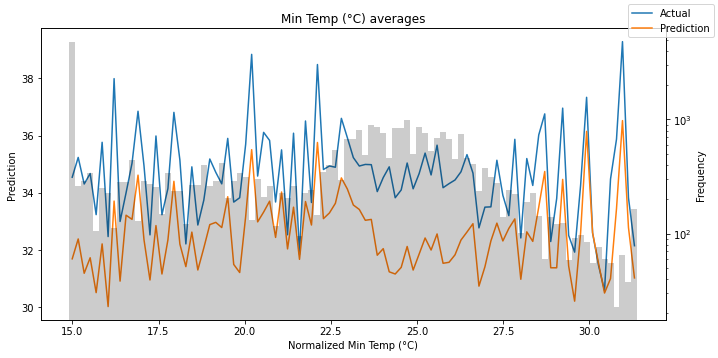

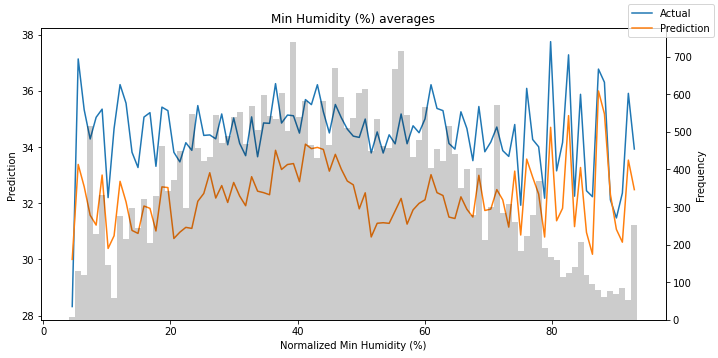

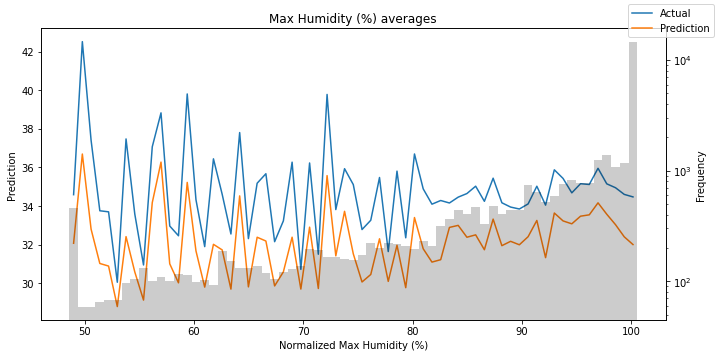

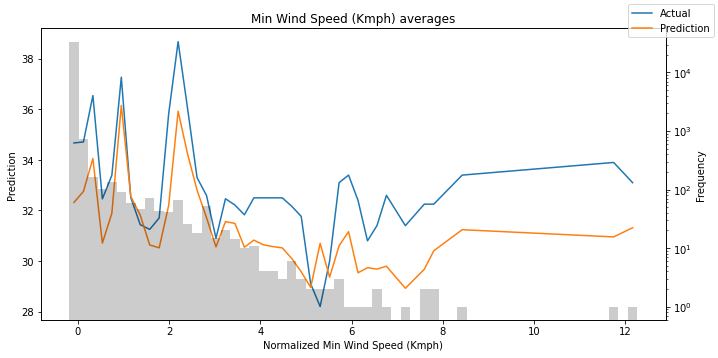

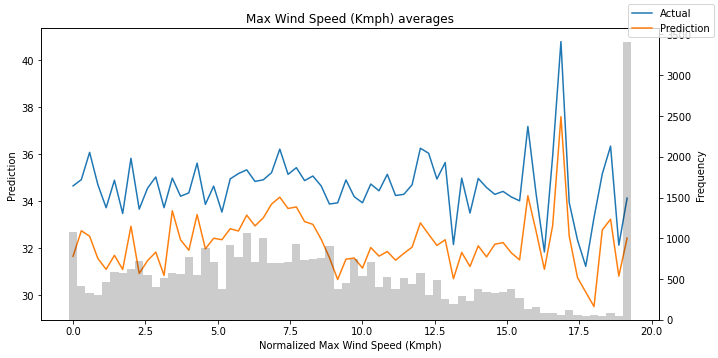

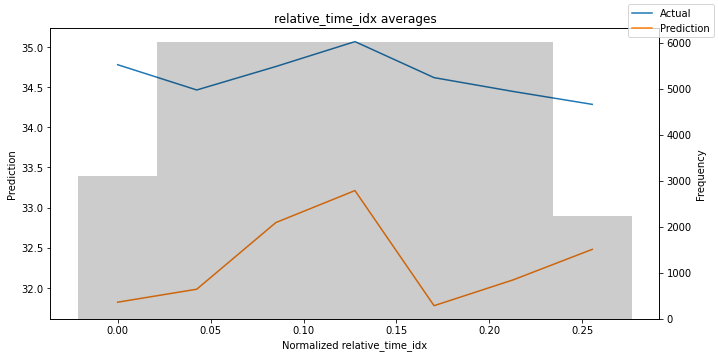

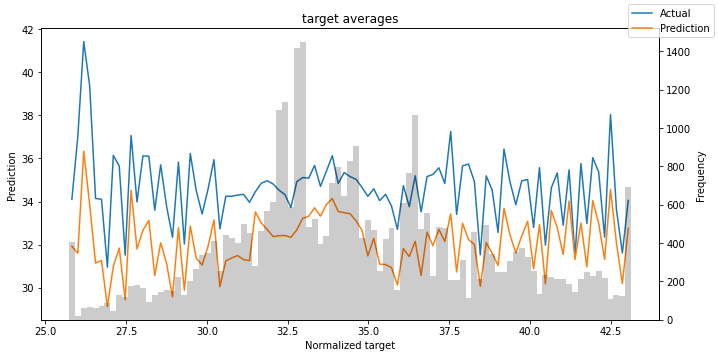

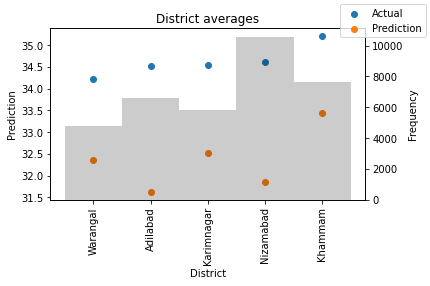

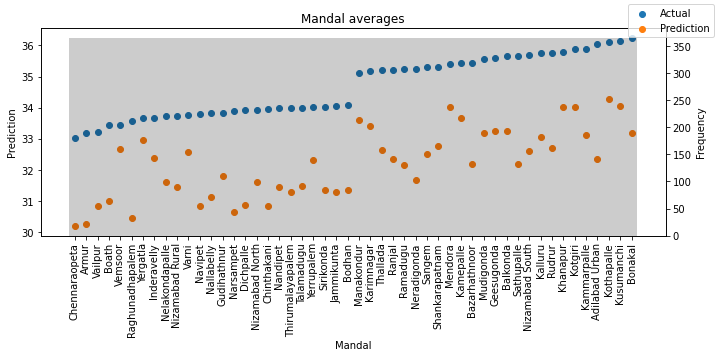

In [182]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

Forecasting - Predict on new data

        District          Mandal       Date  Rain (mm)  Min Temp (°C)  \
0       Adilabad  Adilabad Rural 2019-01-02        0.0            9.1   
1       Adilabad  Adilabad Rural 2019-01-03        0.0           13.0   
2       Adilabad  Adilabad Rural 2019-01-04        0.0            9.9   
3       Adilabad  Adilabad Rural 2019-01-05        0.0           12.7   
4       Adilabad  Adilabad Rural 2019-01-06        0.0           15.0   
...          ...             ...        ...        ...            ...   
174630  Adilabad     Neradigonda 2023-12-31        0.0           14.7   
174631  Adilabad       Sirikonda 2023-12-31        0.0           16.0   
174632  Adilabad      Talamadugu 2023-12-31        0.0           15.8   
174633  Adilabad           Tamsi 2023-12-31        0.0           16.7   
174634  Adilabad           Utnur 2023-12-31        0.0           15.6   

        Max Temp (°C)  Min Humidity (%)  Max Humidity (%)  \
0                28.9              16.6              73.4   
1

/usr/local/lib/python3.8/dist-packages/pytorch_forecasting/data/timeseries.py:1282: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 4 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__District': 'Adilabad', '__group_id__Mandal': 'Bela '}, {'__group_id__District': 'Adilabad', '__group_id__Mandal': 'Boath '}, {'__group_id__District': 'Adilabad', '__group_id__Mandal': 'Jainad '}, {'__group_id__District': 'Adilabad', '__group_id__Mandal': 'Talamadugu '}]
  warnings.warn(


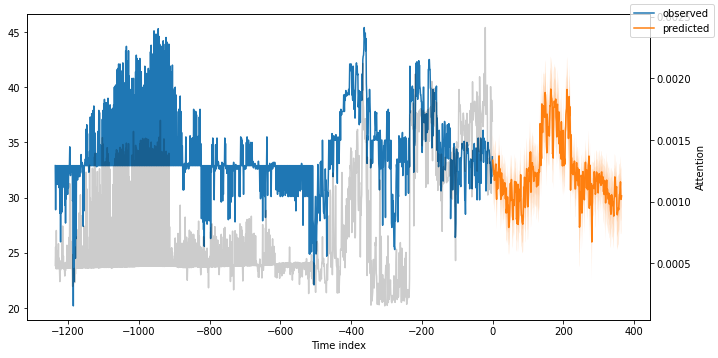

In [183]:
# select last 1460 days from data (max_encoder_length is 1460)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the data
# in a real world dataset, 
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(Date=lambda x: x.Date + pd.offsets.DateOffset(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"

Date1 = decoder_data['Date'].min()
decoder_data["time_idx"] = decoder_data['Date'] - Date1
decoder_data["time_idx"] = decoder_data["time_idx"].dt.days

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
fig, ax = plt.subplots(figsize=(10, 5))

#create out-of-sample predictions for District Adilabad for Jan 2023 to Dec 2023 - 365 days
new_prediction_data=new_prediction_data.query("District == 'Adilabad'")
print(new_prediction_data)
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

#0 to 365 in X-axis depict the day wise maximum temperature prediction from 01-01-2023 to 31-12-2023
best_tft.plot_prediction(new_x, new_raw_predictions, idx=0, show_future_observed=False, ax=ax);

          District          Mandal       Date  Rain (mm)  Min Temp (°C)  \
22815   Karimnagar   Chigurumamidi 2019-01-02        0.0            9.7   
22816   Karimnagar   Chigurumamidi 2019-01-02        0.0            8.8   
22817   Karimnagar   Chigurumamidi 2019-01-03        0.0           12.3   
22818   Karimnagar   Chigurumamidi 2019-01-03        0.0           11.5   
22819   Karimnagar   Chigurumamidi 2019-01-04        0.0           10.6   
...            ...             ...        ...        ...            ...   
174646  Karimnagar        Ramadugu 2023-12-31        0.0           18.1   
174647  Karimnagar  Shankarapatnam 2023-12-31        0.0           19.0   
174648  Karimnagar       Thimmapur 2023-12-31        0.0           17.1   
174649  Karimnagar      V_Saidapur 2023-12-31        0.0           18.6   
174650  Karimnagar      Veenavanka 2023-12-31        0.0           21.7   

        Max Temp (°C)  Min Humidity (%)  Max Humidity (%)  \
22815            28.5              20.

/usr/local/lib/python3.8/dist-packages/pytorch_forecasting/data/timeseries.py:1282: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 2 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__District': 'Karimnagar', '__group_id__Mandal': 'Jammikunta '}, {'__group_id__District': 'Karimnagar', '__group_id__Mandal': 'Manakondur '}]
  warnings.warn(


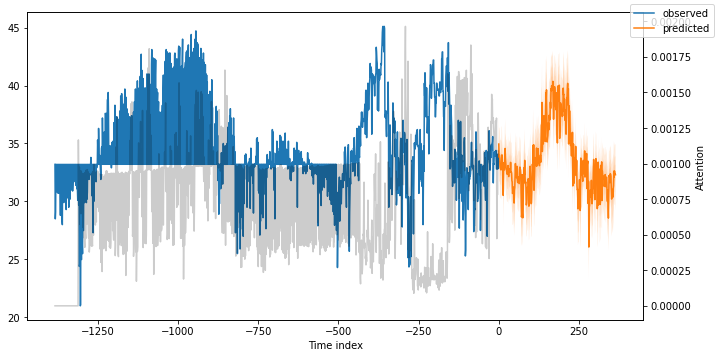

In [184]:
# select last 1460 days from data (max_encoder_length is 1460)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the data
# in a real world dataset, 
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(Date=lambda x: x.Date + pd.offsets.DateOffset(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"

Date1 = decoder_data['Date'].min()
decoder_data["time_idx"] = decoder_data['Date'] - Date1
decoder_data["time_idx"] = decoder_data["time_idx"].dt.days

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
fig, ax = plt.subplots(figsize=(10, 5))

#create out-of-sample predictions for District Karimnagar for Jan 2023 to Dec 2023 - 365 days
new_prediction_data=new_prediction_data.query("District == 'Karimnagar'")
print(new_prediction_data)
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

#0 to 365 in X-axis depict the day wise maximum temperature prediction from 01-01-2023 to 31-12-2023
best_tft.plot_prediction(new_x, new_raw_predictions, idx=0, show_future_observed=False, ax=ax);

       District            Mandal       Date  Rain (mm)  Min Temp (°C)  \
44218   Khammam           Bonakal 2019-01-02        0.0           11.7   
44219   Khammam           Bonakal 2019-01-03        0.0           15.3   
44220   Khammam           Bonakal 2019-01-04        0.0           15.4   
44221   Khammam           Bonakal 2019-01-05        0.0           15.7   
44222   Khammam           Bonakal 2019-01-06        0.0           16.4   
...         ...               ...        ...        ...            ...   
174667  Khammam          Thallada 2023-12-31        0.0           21.5   
174668  Khammam  Thirumalayapalem 2023-12-31        0.0           19.9   
174669  Khammam           Vemsoor 2023-12-31        0.0           21.5   
174670  Khammam              Wyra 2023-12-31        0.0           20.8   
174671  Khammam        Yerrupalem 2023-12-31        0.0           20.1   

        Max Temp (°C)  Min Humidity (%)  Max Humidity (%)  \
44218            32.2              33.9           

/usr/local/lib/python3.8/dist-packages/pytorch_forecasting/data/timeseries.py:1282: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 2 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__District': 'Khammam', '__group_id__Mandal': 'Raghunadhapalem '}, {'__group_id__District': 'Khammam', '__group_id__Mandal': 'Tirumalayapalem'}]
  warnings.warn(


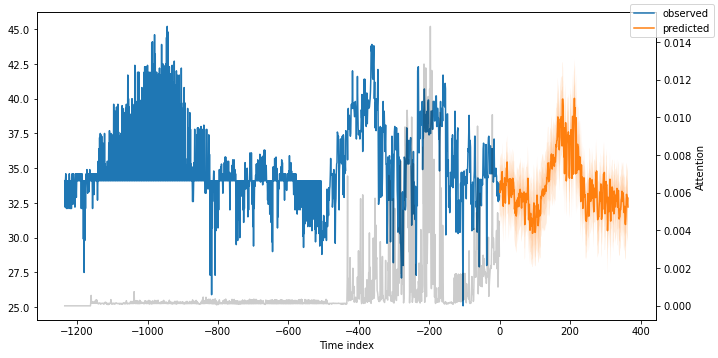

In [186]:
# select last 1460 days from data (max_encoder_length is 1460)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the data
# in a real world dataset, 
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(Date=lambda x: x.Date + pd.offsets.DateOffset(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"

Date1 = decoder_data['Date'].min()
decoder_data["time_idx"] = decoder_data['Date'] - Date1
decoder_data["time_idx"] = decoder_data["time_idx"].dt.days

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
fig, ax = plt.subplots(figsize=(10, 5))

#create out-of-sample predictions for District khammam for Jan 2023 to Dec 2023 - 365 days
new_prediction_data=new_prediction_data.query("District == 'Khammam'")
print(new_prediction_data)
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

#0 to 365 in X-axis depict the day wise maximum temperature prediction from 01-01-2023 to 31-12-2023
best_tft.plot_prediction(new_x, new_raw_predictions, idx=0, show_future_observed=False, ax=ax);

         District     Mandal       Date  Rain (mm)  Min Temp (°C)  \
72987   Nizamabad      Armur 2019-01-02        0.0           15.0   
72988   Nizamabad      Armur 2019-01-02        0.0           14.2   
72989   Nizamabad      Armur 2019-01-02        0.0           12.9   
72990   Nizamabad      Armur 2019-01-02        0.0            9.1   
72991   Nizamabad      Armur 2019-01-03        0.0           15.0   
...           ...        ...        ...        ...            ...   
174696  Nizamabad   Sirkonda 2023-12-31        0.0           16.6   
174697  Nizamabad    Vailpur 2023-12-31        0.0           17.0   
174698  Nizamabad      Varni 2023-12-31        0.0           20.0   
174699  Nizamabad  Yedapalle 2023-12-31        0.0           16.8   
174700  Nizamabad   Yergatla 2023-12-31        0.0           17.8   

        Max Temp (°C)  Min Humidity (%)  Max Humidity (%)  \
72987            30.4              18.8              82.0   
72988            30.7              19.0          

/usr/local/lib/python3.8/dist-packages/pytorch_forecasting/data/timeseries.py:1282: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 2 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__District': 'Nizamabad', '__group_id__Mandal': 'Armur '}, {'__group_id__District': 'Nizamabad', '__group_id__Mandal': 'Kammarpalle '}]
  warnings.warn(


RuntimeError: ignored

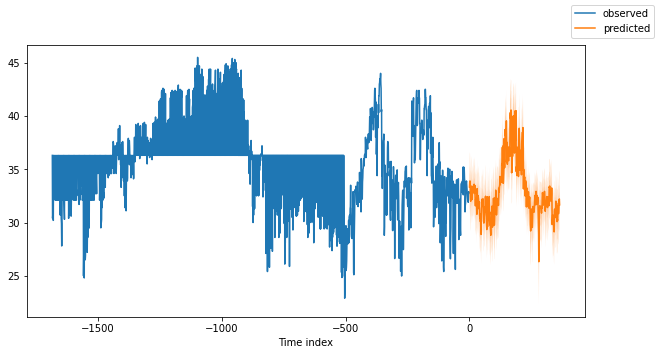

In [188]:
# select last 1460 days from data (max_encoder_length is 1460)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the data
# in a real world dataset, 
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(Date=lambda x: x.Date + pd.offsets.DateOffset(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"

Date1 = decoder_data['Date'].min()
decoder_data["time_idx"] = decoder_data['Date'] - Date1
decoder_data["time_idx"] = decoder_data["time_idx"].dt.days

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
fig, ax = plt.subplots(figsize=(10, 5))

#create out-of-sample predictions for District Nizamabad for Jan 2023 to Dec 2023 - 365 days
new_prediction_data=new_prediction_data.query("District == 'Nizamabad'")
print(new_prediction_data)
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

#0 to 365 in X-axis depict the day wise maximum temperature prediction from 01-01-2023 to 31-12-2023
best_tft.plot_prediction(new_x, new_raw_predictions, idx=0, show_future_observed=False, ax=ax);

        District        Mandal       Date  Rain (mm)  Min Temp (°C)  \
110429  Warangal       Atmakur 2019-01-02        0.0            7.0   
110430  Warangal       Atmakur 2019-01-03        0.0            9.2   
110431  Warangal       Atmakur 2019-01-04        0.0           10.0   
110432  Warangal       Atmakur 2019-01-05        0.0           11.9   
110433  Warangal       Atmakur 2019-01-06        0.0           11.6   
...          ...           ...        ...        ...            ...   
174708  Warangal      Nekkonda 2023-12-31        0.0           16.9   
174709  Warangal  Parvathagiri 2023-12-31        0.0           18.0   
174710  Warangal     Raiparthy 2023-12-31        0.0           19.6   
174711  Warangal        Sangem 2023-12-31        0.0           17.6   
174712  Warangal      Warangal 2023-12-31        0.0           19.8   

        Max Temp (°C)  Min Humidity (%)  Max Humidity (%)  \
110429           29.3              21.3             100.0   
110430           30.7    

/usr/local/lib/python3.8/dist-packages/pytorch_forecasting/data/timeseries.py:1282: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 14 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__District': 'Warangal', '__group_id__Mandal': 'Atmakur'}, {'__group_id__District': 'Warangal', '__group_id__Mandal': 'Bheemadevarapalle'}, {'__group_id__District': 'Warangal', '__group_id__Mandal': 'Damera'}, {'__group_id__District': 'Warangal', '__group_id__Mandal': 'Dharmasagar'}, {'__group_id__District': 'Warangal', '__group_id__Mandal': 'Elkathurthi'}, {'__group_id__District': 'Warangal', '__group_id__Mandal': 'Hanamkonda'}, {'__group_id__District': 'Warangal', '__group_id__Mandal': 'Hasanparthy'}, {'__group_id__District': 'Warangal', '__group_id__Mandal': 'Inole'}, {'__group_id__District': 'Warangal', '__group_id__Mandal

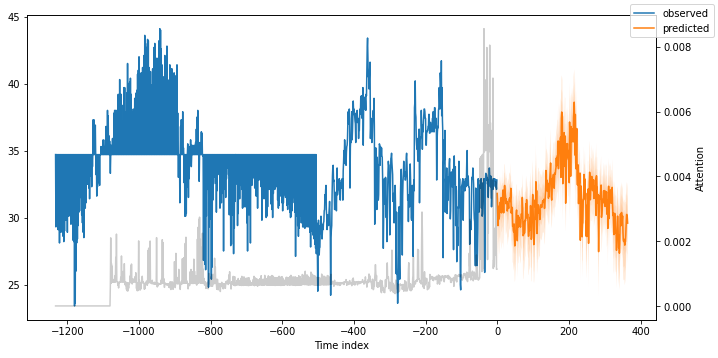

In [189]:
# select last 1460 days from data (max_encoder_length is 1460)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the data
# in a real world dataset, 
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(Date=lambda x: x.Date + pd.offsets.DateOffset(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"

Date1 = decoder_data['Date'].min()
decoder_data["time_idx"] = decoder_data['Date'] - Date1
decoder_data["time_idx"] = decoder_data["time_idx"].dt.days

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
fig, ax = plt.subplots(figsize=(10, 5))

#create out-of-sample predictions for District Warangal for Jan 2023 to Dec 2023 - 365 days
new_prediction_data=new_prediction_data.query("District == 'Warangal'")
print(new_prediction_data)
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

#0 to 365 in X-axis depict the day wise maximum temperature prediction from 01-01-2023 to 31-12-2023
best_tft.plot_prediction(new_x, new_raw_predictions, idx=0, show_future_observed=False, ax=ax);

In [190]:
decoder_data.to_csv(r'/content/2023Predictions.csv', index = None, header=True)

/usr/local/lib/python3.8/dist-packages/pytorch_forecasting/data/timeseries.py:1282: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 14 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__District': 'Warangal', '__group_id__Mandal': 'Atmakur'}, {'__group_id__District': 'Warangal', '__group_id__Mandal': 'Bheemadevarapalle'}, {'__group_id__District': 'Warangal', '__group_id__Mandal': 'Damera'}, {'__group_id__District': 'Warangal', '__group_id__Mandal': 'Dharmasagar'}, {'__group_id__District': 'Warangal', '__group_id__Mandal': 'Elkathurthi'}, {'__group_id__District': 'Warangal', '__group_id__Mandal': 'Hanamkonda'}, {'__group_id__District': 'Warangal', '__group_id__Mandal': 'Hasanparthy'}, {'__group_id__District': 'Warangal', '__group_id__Mandal': 'Inole'}, {'__group_id__District': 'Warangal', '__group_id__Mandal

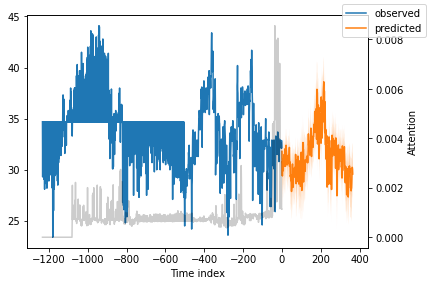

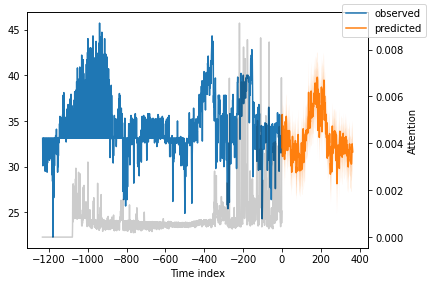

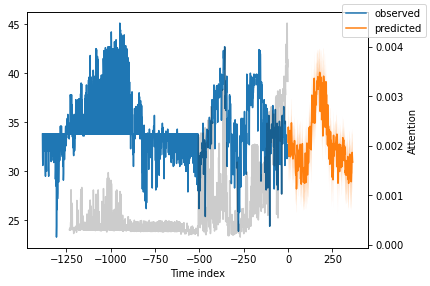

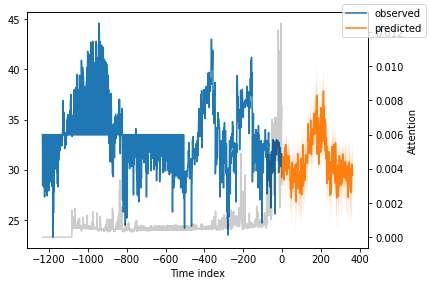

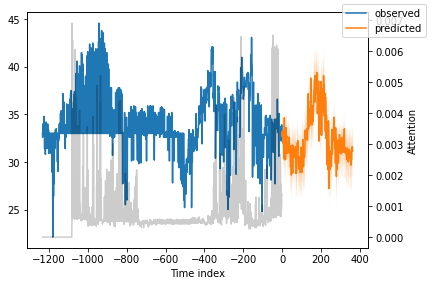

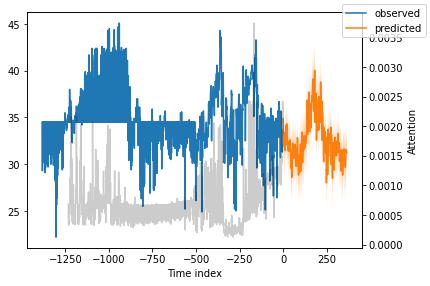

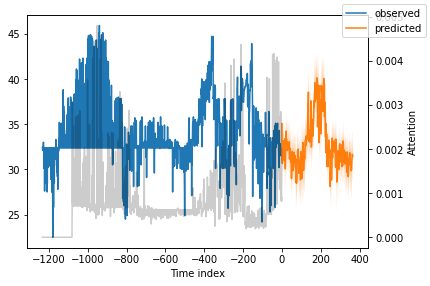

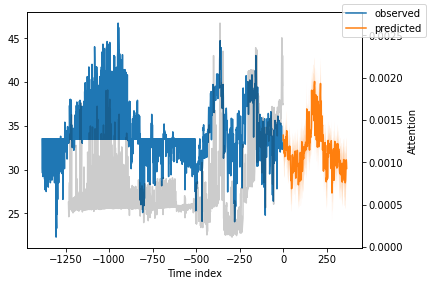

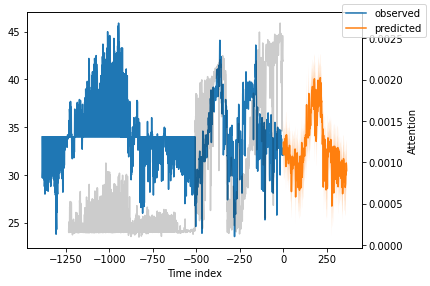

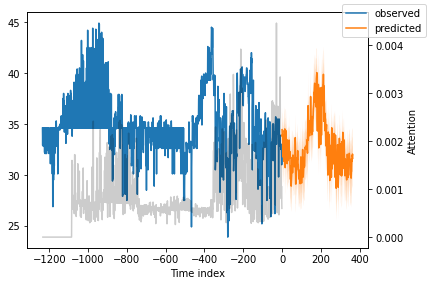

In [191]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);

**Interpret model**

Variable importances

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x234 with 1 Axes>,
 'encoder_variables': <Figure size 504x306 with 1 Axes>,
 'decoder_variables': <Figure size 504x288 with 1 Axes>}

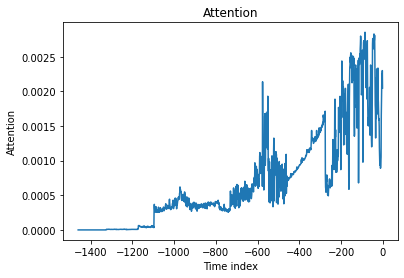

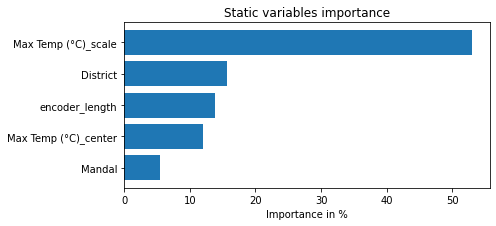

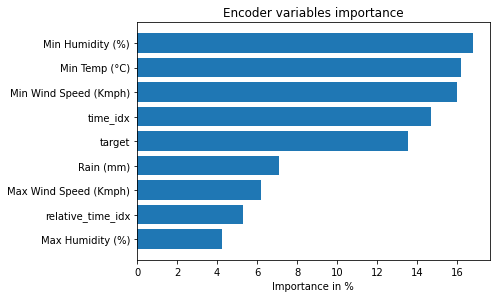

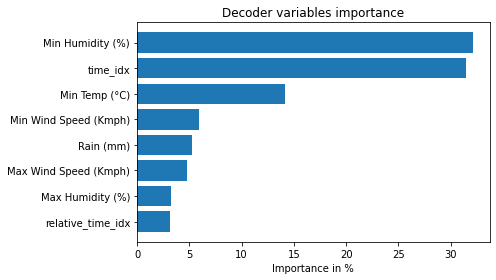

In [192]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)